In [2]:
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random
from collections import Counter

In [3]:
#listing out the directory
directory = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

### **Data Importation**

In [ ]:
# Initialize a list to hold the data
data = []

# Loop through each category
for category in tqdm(categories, desc="Processing Categories"):

    category_path = os.path.join(directory, category)

    # Check if the directory exists
    if os.path.exists(category_path):
        # Loop through each file in the category directory
        for file_name in tqdm(os.listdir(category_path), desc=f"Processing Files in {category}", leave=False):
            file_path = os.path.join(category_path, file_name)

            # Check if it's a file (to avoid directories)
            if os.path.isfile(file_path):
                # Append the file path and label to the data list
                data.append((file_path, category))
    else:
        print(f"Directory not found: {category_path}")

# Randomize the data
random.shuffle(data)
# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['File_Path', 'Label'])


# Define label encoding
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

# Map the labels to their corresponding numerical values
df['Encoded_Label'] = df['Label'].map(label_encoding)

# Display the first few rows of the DataFrame
df.head()

Processing Categories: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]                


,File_Path,Label,Encoded_Label
0,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Malignant cases,1
1,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Normal cases,2
2,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Normal cases,2
3,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Normal cases,2
4,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Malignant cases,1


### **Data Cleaning and Conversion**

In [83]:
# Define the target image size
img_size = 256

# Function to process images: resize to 256x256, convert to grayscale
def process_image(file_path):
    # Read the image in grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Resize the image
        img_resized = cv2.resize(img, (img_size, img_size))
        return img_resized  # Return as a 2D numpy array
    else:
        print(f"Image not found or could not be read: {file_path}")
        return None

# Use tqdm to apply the function with a progress bar
tqdm.pandas(desc="Processing Images")
df['Processed_Image'] = df['File_Path'].progress_apply(process_image)

# Remove rows with None (failed image processing)
df = df.dropna(subset=['Processed_Image']).reset_index(drop=True)

Processing Images: 100%|██████████| 1097/1097 [00:03<00:00, 311.19it/s]


### **Data Normalization**

In [84]:
import numpy as np

In [95]:
# Convert the column of processed images into a 3D NumPy array
X = [img for img in df['Processed_Image']]  # Collect images into a list
X = np.array(X).reshape(-1, img_size, img_size, 1)  # Add channel dimension
X= X/255.0

y= df['Label']
y= np.array(y)

# Check the shape of the final NumPy array
print(f"Shape of images array: {images_array.shape}")

Shape of images array: (1097, 256, 256, 1)


### **Data Splitting**

In [96]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
#Splitting the data into train, test and validation set
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp, test_size=0.2, random_state=42)

### **Applying SMOTE**

In [98]:
# Flatten X_train for SMOTE
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_samples, img_size * img_size)

# Apply SMOTE
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled_flattened, y_train_sampled = smote.fit_resample(X_train_flattened, y_train)
print('After SMOTE:', Counter(y_train_sampled))

# Reshape X_train_sampled back to 4D
X_train_sampled = X_train_sampled_flattened.reshape(-1, img_size, img_size, 1)  # Shape: (n_samples, img_size, img_size, 1)

Before SMOTE: Counter({'Malignant cases': 446, 'Normal cases': 332, 'Bengin cases': 99})
After SMOTE: Counter({'Normal cases': 446, 'Malignant cases': 446, 'Bengin cases': 446})


In [107]:
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
y_train_sampled = np.array([label_encoding[label] for label in y_train_sampled])
y_val = np.array([label_encoding[label] for label in y_val])
y_test = np.array([label_encoding[label] for label in y_test])

### **Model Building**

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

In [109]:
# Define L2 regularizer
l2_reg = l2(0.0001)

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], kernel_regularizer=l2_reg))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2_reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))


model1.add(Flatten())
model1.add(Dense(16, kernel_regularizer=l2_reg))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax', kernel_regularizer=l2_reg))

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │       1,843,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,935,939 (7.39 MB)

 Trainable params: 1,935,939 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

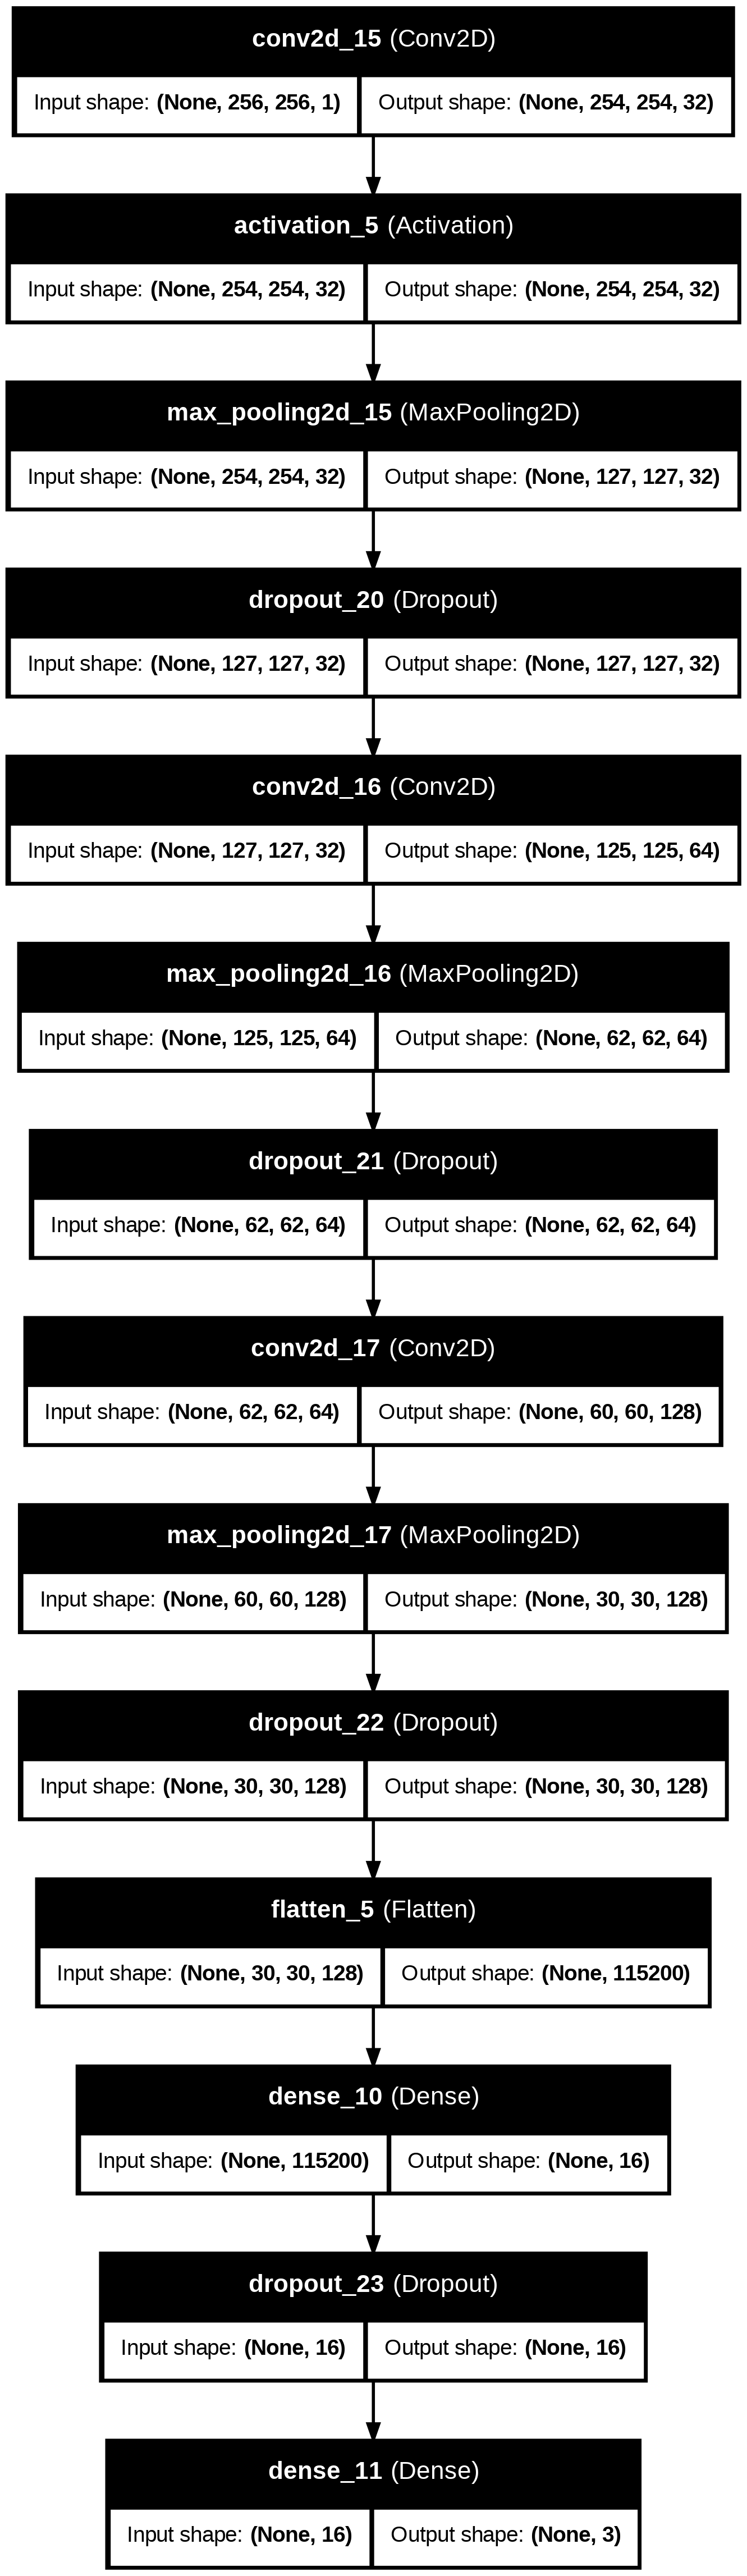

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture to a file
plot_model(
    model1,
    to_file='model_plot.png',
    show_shapes=True,  # Displays the shape of input/output tensors
    show_layer_names=True  # Displays layer names
)


In [112]:
# Step 1: Dencode labels
label_encoding = {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
y_train_encoded = [label_encoding[label] for label in y_train]  # Encode y_train

# Step 2: Count the occurrences of each class in the encoded labels
class_counts = Counter(y_train_encoded)

# Step 3: Calculate weights
new_weights = {
    0: X_train.shape[0] / (3 * class_counts[0]),
    1: X_train.shape[0] / (3 * class_counts[1]),
    2: X_train.shape[0] / (3 * class_counts[2]),
}

new_weights

{0: 2.952861952861953, 1: 0.6554559043348281, 2: 0.8805220883534136}

In [113]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore weights of the best epoch
)

In [ ]:
# Train the model with Early Stopping
model1.fit(
    X_train_sampled,
    y_train_sampled,
    batch_size=8,
    epochs=15,
    validation_data=(X_val, y_val),
    class_weight=new_weights,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.3614 - loss: 2.6127 - val_accuracy: 0.4318 - val_loss: 1.0757
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6281 - loss: 0.9488 - val_accuracy: 0.7727 - val_loss: 0.5493
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8673 - loss: 0.4187 - val_accuracy: 0.8864 - val_loss: 0.3104
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9314 - loss: 0.2450 - val_accuracy: 0.8864 - val_loss: 0.2605
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9265 - loss: 0.2411 - val_accuracy: 0.9318 - val_loss: 0.2137
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9549 - loss: 0.1816 - val_accuracy: 0.9091 - val_loss: 0.2189
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9628 - loss: 0.1649 - val_accuracy: 0.9091 - val_loss: 0.2466
Epoch 8/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9707 - loss: 0.1651 - val_acc

In [134]:
# Predictions from model 1 (probabilities)
y_pred = model1.predict(X_test, verbose=0)
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate Accuracy and F1 Score for model 1
accuracy_model1 = accuracy_score(y_test, y_pred_labels)
f1_model1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Evaluation on Test Data")
print("Model Accuracy: {:.2f}%".format(accuracy_model1*100))
print("Model F1 Score: {:.2f}%".format(f1_model1*100))

Evaluation on Test Data
Model Accuracy: 98.30%
Model F1 Score: 98.29%


In [129]:
#saving the model
model1.save("Ismail_lung_model.h5")

### **Converting to TensorFlow Lite**

In [131]:
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the converted TFLite model
with open('Ismail-Lung-Model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite format successfully!")

Saved artifact at '/tmp/tmpm217m41j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='keras_tensor_530')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136836329605776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329608240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329768912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329771376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329779472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329781760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329987712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329992112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836329985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136836331458928: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model conver

In [132]:
os.listdir()

['Ismail-Lung-Model.tflite',
 'model_plot.png',
 '.virtual_documents',
 'Ismail_lung_model.h5']

In [133]:
# Define the source and destination paths
source_model1 = 'Ismail-Lung-Model.tflite'
source_model2 = 'Ismail_lung_model.h5'
destination_dir = '/kaggle/working/'

# Move the models to the /kaggle/working/ directory
os.rename(source_model1, os.path.join(destination_dir, source_model1))
os.rename(source_model2, os.path.join(destination_dir, source_model2))

print("Models moved to the /kaggle/working/ directory.")

Models moved to the /kaggle/working/ directory.
